In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [24]:
uk = df[df.Country == 'United Kingdom'].reset_index(drop=True)
uk.InvoiceDate = pd.to_datetime(uk.InvoiceDate)

## Recency

In [25]:
uk_user = pd.DataFrame(uk['CustomerID'].unique())
uk_user.columns = ['CustomerID']

In [26]:
uk_max_purchase = uk.groupby('CustomerID').InvoiceDate.max().reset_index()
uk_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [27]:
uk_max_purchase.head(3)

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00


In [15]:
uk_max_purchase.MaxPurchaseDate = pd.to_datetime(uk_max_purchase.MaxPurchaseDate)

In [28]:
uk_max_purchase['Recency'] = (uk_max_purchase.MaxPurchaseDate.max() - uk_max_purchase.MaxPurchaseDate).dt.days

In [29]:
uk_user = pd.merge(uk_user, uk_max_purchase[['CustomerID','Recency']], on='CustomerID')
uk_user.head(3)

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95


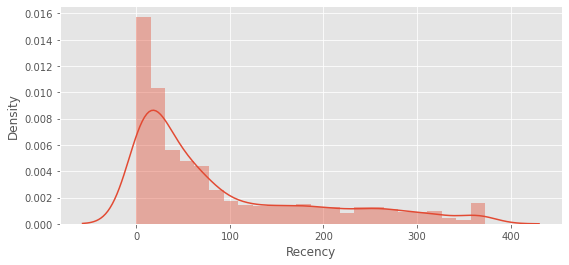

In [30]:
plt.figure(figsize=(9,4))
sns.distplot(uk_user.Recency);

In [31]:
uk_user.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [32]:
from sklearn.cluster import KMeans

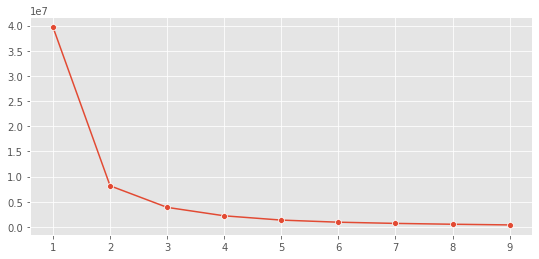

In [33]:
uk_recency = uk_user[['Recency']]

wcss = []
for k in range(1,10):
    model = KMeans(n_clusters = k, max_iter=1000, random_state = 42).fit(uk_recency)
    wcss.append(model.inertia_)

plt.figure(figsize=(9,4))
sns.lineplot(range(1,10), wcss, marker = 'o');

In [34]:
kmeans = KMeans(n_clusters=4).fit(uk_user[['Recency']])
uk_user['RecencyCluster'] = kmeans.predict(uk_user[['Recency']])

In [35]:
uk_user.head(3)

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,3
2,13748.0,95,0


In [36]:
def order_cluster(cluster_field_name, target_field_name, df, ascending=False):
    df_idx = df.groupby(cluster_field_name)[target_field_name].mean().sort_values(ascending=ascending).reset_index()
    df_idx['index'] = df_idx.index
    df_last = pd.merge(df, df_idx[[cluster_field_name,'index']], on=cluster_field_name)
    df_last = df_last.drop([cluster_field_name], axis=1)
    df_last = df_last.rename(columns={'index':cluster_field_name})
    return df_last

In [37]:
uk_user = order_cluster('RecencyCluster', 'Recency', uk_user)

In [38]:
uk_user.groupby('RecencyCluster').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.0,373.0
1,570.0,184.436842,31.856230,131.0,156.00,184.0,211.0,244.0
2,952.0,77.567227,22.743569,48.0,59.00,72.0,93.0,130.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.0,47.0


## Frequency

In [39]:
uk_frequency = uk.groupby('CustomerID').InvoiceDate.count().reset_index()
uk_frequency.columns = ['CustomerID','Frequency']

In [40]:
uk_user = pd.merge(uk_user, uk_frequency, on='CustomerID')

In [41]:
uk_user.head(3)

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13


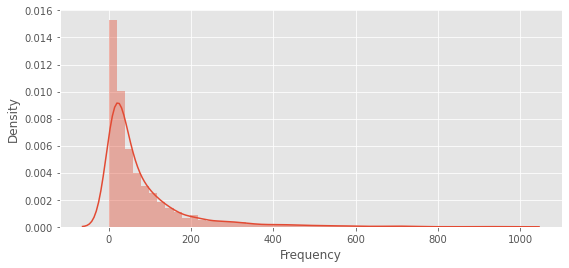

In [42]:
plt.figure(figsize=(9,4))
sns.distplot(uk_user.Frequency[uk_user.Frequency < 1000]);

In [43]:
kmeans = KMeans(n_clusters=4).fit(uk_user[['Frequency']])
uk_user['FrequencyCluster'] = kmeans.predict(uk_user[['Frequency']])

In [44]:
uk_user = order_cluster('FrequencyCluster', 'Frequency', uk_user, True)

In [45]:
uk_user.groupby('FrequencyCluster').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3495.0,49.485551,44.897776,1.0,15.00,33.0,73.0,189.0
1,430.0,330.893023,133.873745,190.0,227.25,287.0,398.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.50,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.00,5128.0,6555.5,7983.0


## Revenue (Monetary)

In [49]:
uk['Revenue'] = uk.UnitPrice * uk.Quantity

In [50]:
uk_revenue = uk.groupby('CustomerID').Revenue.sum().reset_index()
uk_revenue.columns = ['CustomerID','Revenue']

In [51]:
uk_user = pd.merge(uk_user, uk_revenue, on='CustomerID')

In [52]:
uk_user.head(3)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10


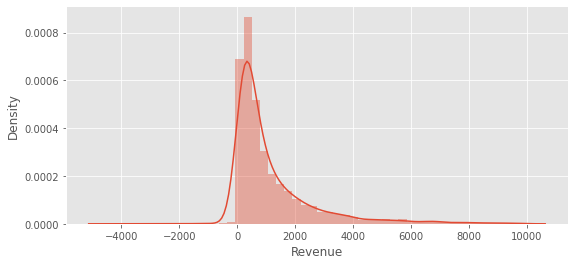

In [53]:
plt.figure(figsize=(9,4))
sns.distplot(uk_user.Revenue[uk_user.Revenue < 10000]);

In [54]:
kmeans = KMeans(n_clusters=4).fit(uk_user[['Revenue']])
uk_user['RevenueCluster'] = kmeans.predict(uk_user[['Revenue']])

In [55]:
uk_user = order_cluster('RevenueCluster', 'Revenue', uk_user, True)

In [56]:
uk_user.groupby('RevenueCluster').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3685.0,905.408707,918.748665,-4287.63,262.6800,572.451,1256.190,4277.66
1,236.0,7731.439110,3635.525217,4301.22,5148.9825,6515.320,9091.275,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.4900,36351.420,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.2500,221960.330,239199.410,256438.49


## Overall Score

In [57]:
uk_user['OverallScore'] = uk_user['RecencyCluster'] + uk_user['FrequencyCluster'] + uk_user['RevenueCluster']
uk_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.170213,32.569149,499.035215
2,78.870229,47.044711,864.548497
3,20.737748,68.321192,1090.846458
4,14.906667,270.720000,3603.939033
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


In [58]:
uk_user['Segment'] = 'Low-Value'
uk_user.loc[uk_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
uk_user.loc[uk_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [59]:
uk_user.head(3)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value


In [60]:
uk_graph = uk_user[(uk_user.Revenue < 50000) & (uk_user.Frequency < 2000)]

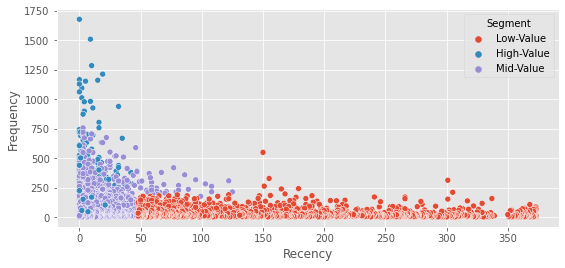

In [61]:
plt.figure(figsize=(9,4))
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=uk_graph);

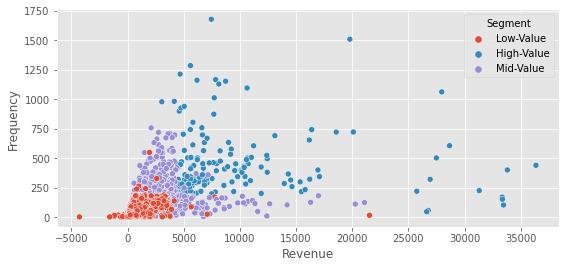

In [62]:
plt.figure(figsize=(9,4))
sns.scatterplot(x='Revenue', y='Frequency', hue='Segment', data=uk_graph);

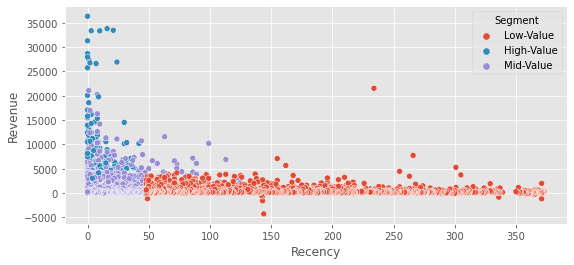

In [63]:
plt.figure(figsize=(9,4))
sns.scatterplot(x='Recency', y='Revenue', hue='Segment', data=uk_graph);